In [1]:
from os import getcwd
from os.path import join, abspath, pardir
from json import dump
import geopandas as gp
from shapely.geometry import LineString
import pandas as pd
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

/opt/homebrew/anaconda3/envs/data_mining/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


##### Configs

In [2]:
parent_dir = abspath(join(getcwd(), pardir))
shape_files_dir = join(parent_dir, "2109_STIB_MIVB_Network")
gps_files_dir = join(parent_dir, "GPS")
line_shape_file = join(shape_files_dir, "ACTU_LINES.shp")
stops_shape_file = join(shape_files_dir, "ACTU_STOPS.shp")

##### Load files

In [3]:
line_df = gp.read_file(line_shape_file)
stops_df = gp.read_file(stops_shape_file)

##### Helper functions for prediction of mode transport

In [4]:
def get_list_threshold(min=1, max=100):
    return [x for x in range(int(min), int(max)) if all(x % t for t in range(2, x))]

def get_spatial_join(df1, df2, threshold_list, column=None, **kwargs):
    if not isinstance(df1, gp.GeoDataFrame): raise ValueError("Kindly, pass a valid geo pandas dataframe.")
    if not isinstance(df2, gp.GeoDataFrame): raise ValueError("Kindly, pass a valid geo pandas dataframe.")
    if (not isinstance(threshold_list, list)) or (not len(threshold_list)): raise ValueError("Kindly, pass a valid threshold list.")
    
    # Make sure both geo-panda dataframes 'df1' & 'df2' have the same coordinate reference system (crs)
    if df1.crs != df2.crs:
        df1 = df1.to_crs(df2.crs)
    
    _threshold_ = float(0)
    df = None
    for threshold in threshold_list:
        df = df2.sjoin_nearest(df1, max_distance=float(threshold), distance_col="distances", **kwargs)
        if not df.empty:
            _threshold_ = threshold
            break
    if (column is None) or (column not in df.columns.to_list()):
        return _threshold_, list(), df
    else:
        return _threshold_, list(df[column].unique()), df
    
def get_intersection(list_1, list_2):
    if (not isinstance(list_1, list)) or (not isinstance(list_2, list)): raise ValueError("Kindly, pass a valid list for intersection.")
    
    return list( set(list_1).intersection( set(list_2) ) )

def plot_tracks(track_df, df, modes, col='LIGNE', title=str()):
    colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    fig, ax = plt.subplots(figsize=(15, 15))
    track_df.to_crs(df.crs).plot(ax=ax, alpha=0.7, color="pink")
    for i, mode in enumerate(modes):
        df.loc[df[col].isin(modes)].plot(ax=ax, cmap=colors[i])
    fig.suptitle(title)
    return fig, ax

##### Predict the mode of transport for each GPS track

In [25]:
def predict_transport_mode(gps_df, line_df, stops_df, detailed_analysis=False):
    if not isinstance(gps_df, pd.DataFrame): raise ValueError("Kindly, pass the gps track(s) data as a pandas dataframe.")
    if not isinstance(stops_df, gp.GeoDataFrame): raise ValueError("Kindly, pass the stops data as a geo pandas dataframe.")
    if not isinstance(line_df, gp.GeoDataFrame): raise ValueError("Kindly, pass the stops data as a geo pandas dataframe.")
    
    # Get list of all the tracks in the GPS data
    tracks = list(gps_df['TrackId'].unique())
    
    # Max. threshold for max_dist (in meters)
    max_dist_threshold = float(100)
    
    # List of thresholds for lines and stops
    lines_max_dist_threshold = get_list_threshold(1, max_dist_threshold)
    stops_max_dist_threshold = get_list_threshold(5, max_dist_threshold)
    
    # For result
    Result = namedtuple('Result', ['track_id', 'mode', 'nearest', 'modes', 'fig', 'ax'])
    results = dict()
    
    # For each GPS track
    for track in tracks:
        
        # 1. Get 'track' data from gps_df
        track_df = gps_df.loc[gps_df['TrackId'].isin([track])]
        
        # 2. Convert into geo-pandas dataframe with coordinate reference system (crs) of '4326' (WGS 84)
        track_df = gp.GeoDataFrame(track_df, geometry=gp.points_from_xy(track_df['lon'], track_df['lat']), crs=4326)
        
        # 3. Get spatial join with lines
        line_max_dist_threshold, closest_lines, track_line_df = get_spatial_join(track_df, line_df, threshold_list=lines_max_dist_threshold, column="LIGNE")

        # 4. Get spatial join with stops
        stop_max_dist_threshold, closest_stops, track_stop_df = get_spatial_join(track_df, stops_df, threshold_list=stops_max_dist_threshold, column="Code_Ligne")
        
        # 5. Get intersection of common modes
        modes = get_intersection(closest_lines, closest_stops)
        
        # Sanity check (if no modes) -> probably the mode is "others"
        if not len(modes):
            results[track] = Result(track_id=track, mode="others", nearest="others", modes=list(), fig=None, ax=None)
            continue
                
        # 6. Save the plots for later usage (maybe)
        # fig, ax = plot_tracks(track_df, line_df, modes, 'LIGNE', "Track {}".format(track))
        
        # 7. For each transport mode, get the variant for each track and store it's geometry (for next step)
        # Also, change the coordinate reference system (crs) from '4326' to same as the 'line_df' one.
        modes_line_geo = dict()
        track_result = dict(others=0)
        track_df = track_df.to_crs(line_df.crs)
        for mode in modes:
            line_t = line_df.loc[line_df['LIGNE'].isin([mode])]
            variant_t = list(track_line_df.loc[track_line_df['LIGNE'].isin([mode])]['VARIANTE'].unique())
            line_t = line_t.loc[line_t['VARIANTE'].isin(variant_t)]

            modes_line_geo[mode] = list(line_t['geometry'])[0]
            track_result[mode] = 0
        
        # 8. For each point in our track, calculate the distance and see which mode is closer, increment the one which is closer. 
        # If the nearest point has more distance than the "max_dist_threshold", then increment the "others" count
        max_dist_threshold = float(20)
        track_points = list(track_df['geometry'])
        for track_point in track_points:
            distance = dict()
            for mode in modes:
                line_geo = modes_line_geo[mode]
                nearest = nearest_points(line_geo, track_point)[0]
                nearest_distance = nearest.distance(track_point)
                distance[mode] = nearest_distance
            nearest = min(distance, key=lambda k: distance[k])
            if distance[nearest] > max_dist_threshold: nearest = 'others'
            track_result[nearest] = track_result[nearest] + 1

        # 9. Convert to probabilities
        for key in list(track_result.keys()):
            track_result[key] = (float(track_result[key]) / len(track_points)) * 100
            
        # 10. Get the nearest point
        _max_probability_ = max(track_result, key=lambda k: track_result[k])
        _nearest_ = track_result[_max_probability_]
        
        _mode_ = "others"
        
        if _max_probability_.find("b") != -1:
            _mode_ = "bus"
        elif _max_probability_.find("t") != -1 and _max_probability_ != "others":
            _mode_ = "tram"
        elif _max_probability_.find("m") != -1:
            _mode_ = "metro"

        if _max_probability_ != "others": modes = [_max_probability_]
        fig, ax = plot_tracks(track_df, line_df, modes, 'LIGNE', "Track {}".format(track))
        results[track] = Result(track_id=track, mode=_mode_, nearest=_max_probability_, modes=track_result, fig=fig, ax=ax)
    
    return results

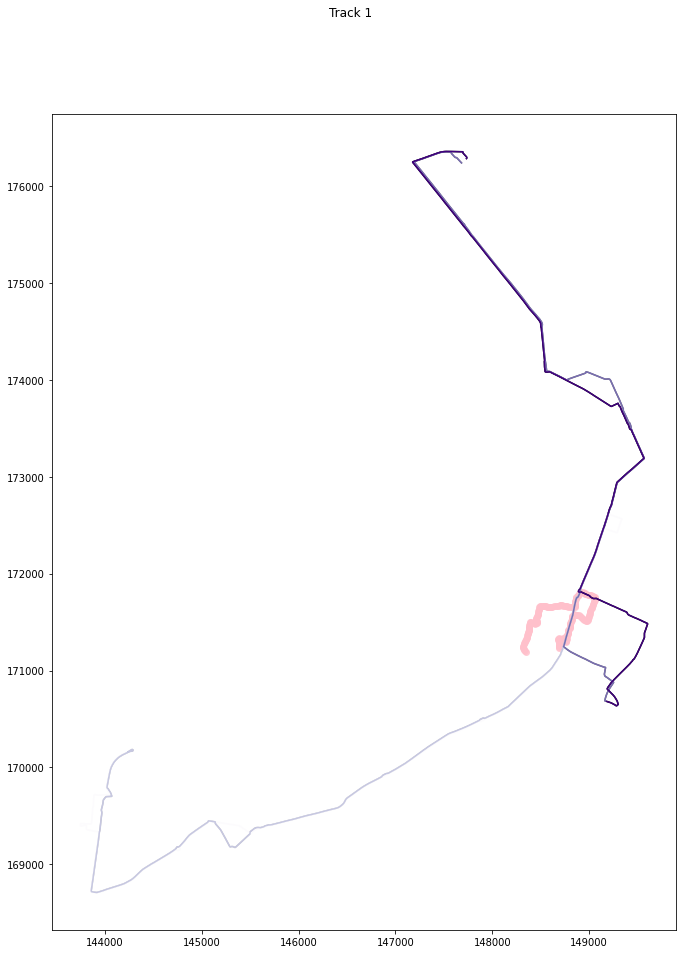

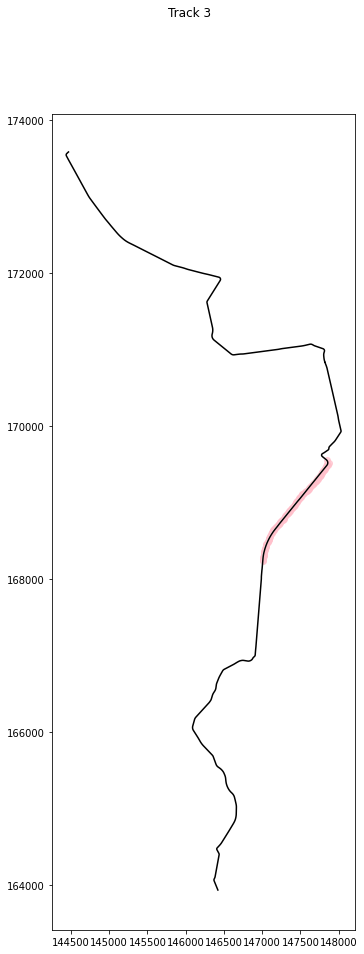

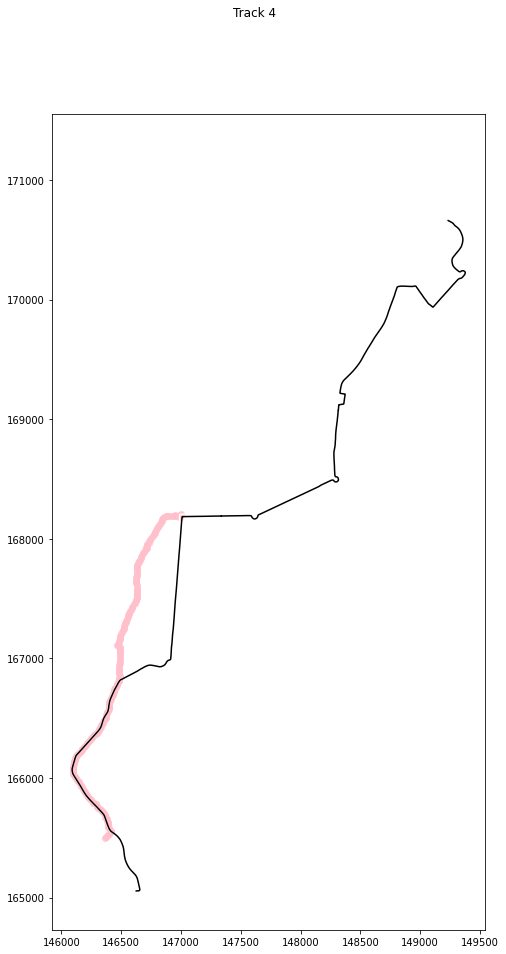

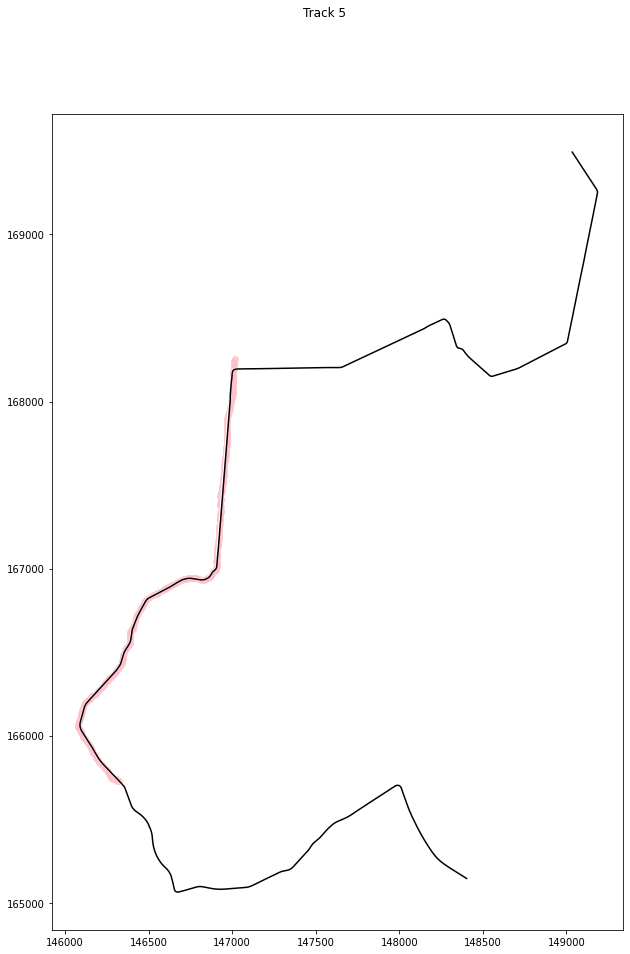

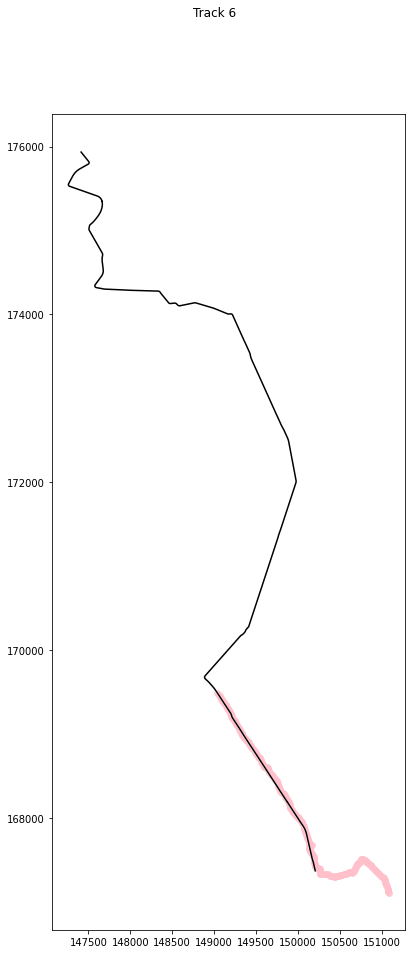

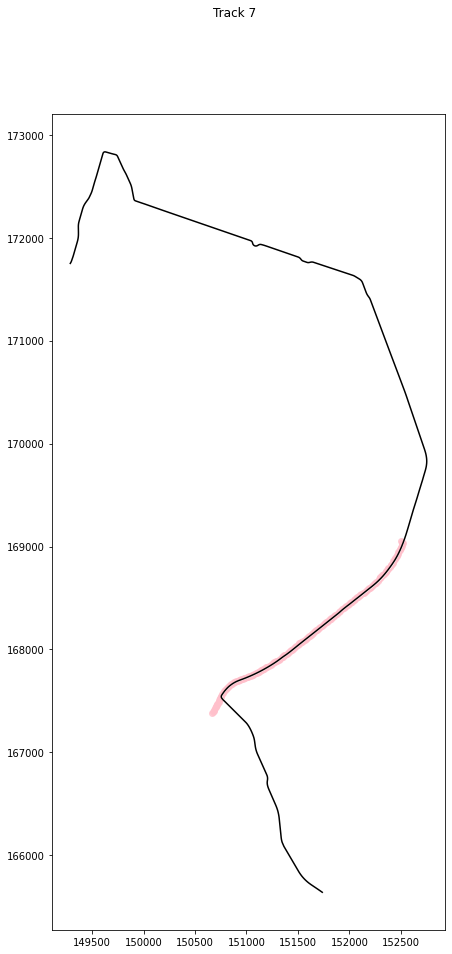

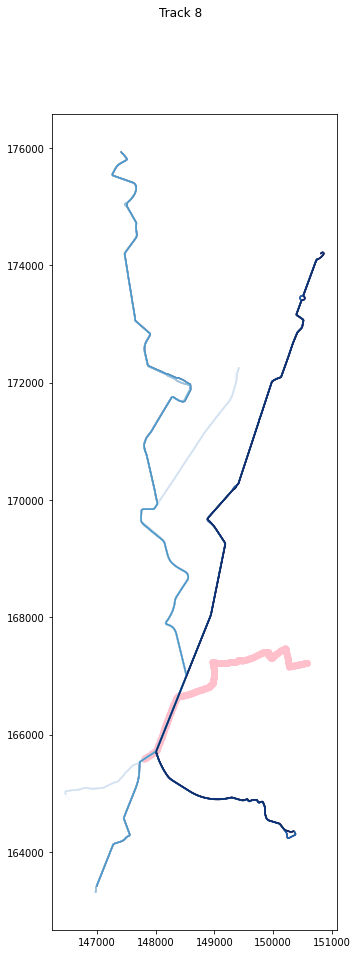

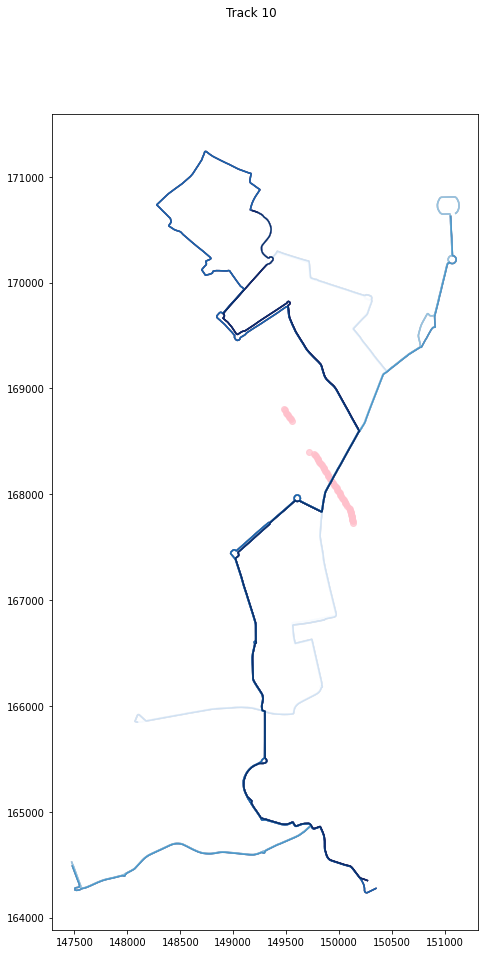

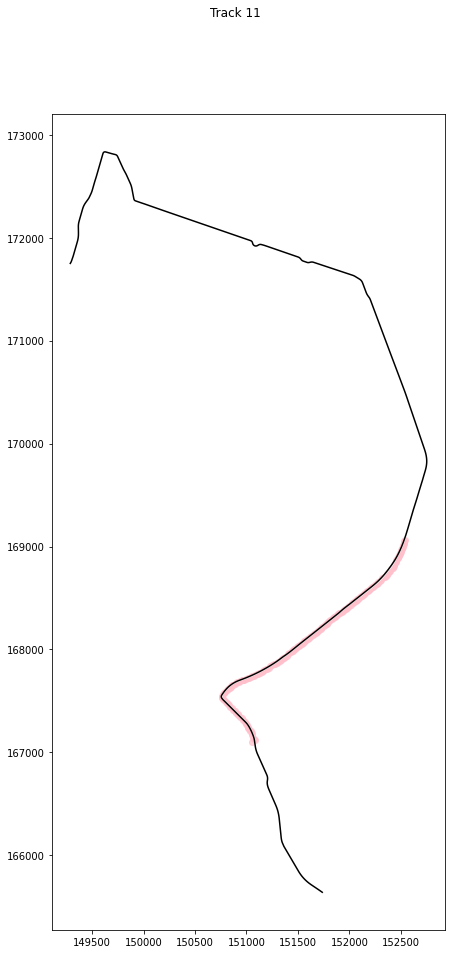

In [26]:
results = predict_transport_mode(gps_df, line_df, stops_df)

In [27]:
results

{1: Result(track_id=1, mode='others', nearest='others', modes={'others': 73.03370786516854, '218b': 26.96629213483146, '046b': 0.0}, fig=<Figure size 1080x1080 with 1 Axes>, ax=<AxesSubplot:>),
 3: Result(track_id=3, mode='tram', nearest='082t', modes={'others': 4.3478260869565215, '082t': 77.39130434782608, '032t': 0.0, '049b': 18.26086956521739, '050b': 0.0}, fig=<Figure size 1080x1080 with 1 Axes>, ax=<AxesSubplot:>),
 4: Result(track_id=4, mode='bus', nearest='212b', modes={'others': 0.0, '054b': 21.16182572614108, '074b': 8.71369294605809, '212b': 29.045643153526974, '097t': 16.182572614107883, '032t': 0.8298755186721992, '050b': 24.066390041493776, '082t': 0.0, '052b': 0.0}, fig=<Figure size 1080x1080 with 1 Axes>, ax=<AxesSubplot:>),
 5: Result(track_id=5, mode='tram', nearest='097t', modes={'others': 0.45871559633027525, '054b': 3.211009174311927, '074b': 0.0, '212b': 15.137614678899084, '097t': 78.89908256880734, '032t': 1.834862385321101, '050b': 0.0, '082t': 0.0, '052b': 0.4

In [31]:
for key in list(results.keys()):
    result = results[key]
    print("Track: {}\tMode: {}\tPredicted: {}\tProbabilities: {}".format(result[0], result[1], result[2], result[3]))

Track: 1	Mode: others	Predicted: others	Probabilities: {'others': 73.03370786516854, '218b': 26.96629213483146, '046b': 0.0}
Track: 3	Mode: tram	Predicted: 082t	Probabilities: {'others': 4.3478260869565215, '082t': 77.39130434782608, '032t': 0.0, '049b': 18.26086956521739, '050b': 0.0}
Track: 4	Mode: bus	Predicted: 212b	Probabilities: {'others': 0.0, '054b': 21.16182572614108, '074b': 8.71369294605809, '212b': 29.045643153526974, '097t': 16.182572614107883, '032t': 0.8298755186721992, '050b': 24.066390041493776, '082t': 0.0, '052b': 0.0}
Track: 5	Mode: tram	Predicted: 097t	Probabilities: {'others': 0.45871559633027525, '054b': 3.211009174311927, '074b': 0.0, '212b': 15.137614678899084, '097t': 78.89908256880734, '032t': 1.834862385321101, '050b': 0.0, '082t': 0.0, '052b': 0.45871559633027525}
Track: 6	Mode: tram	Predicted: 093t	Probabilities: {'others': 15.884476534296029, '093t': 49.09747292418773, '097t': 7.9422382671480145, '025t': 10.830324909747292, '008t': 14.801444043321299, '07

##### Get the GPS Tracks

In [7]:
gps_df = pd.read_csv(join(gps_files_dir, "GPStracks.csv"))
max_dist_threshold = float(100)
lines_max_dist_threshold = get_list_threshold(1, max_dist_threshold)
stops_max_dist_threshold = get_list_threshold(5, max_dist_threshold)

In [8]:
gps_df.head()

,TrackId,lat,lon,time
0,1,50.851152,4.345326,2021-11-16T08:35:24Z
1,1,50.851235,4.345191,2021-11-16T08:35:45Z
2,1,50.851328,4.345069,2021-11-16T08:35:48Z
3,1,50.851403,4.344988,2021-11-16T08:35:51Z
4,1,50.851500,4.344920,2021-11-16T08:35:55Z


In [9]:
tracks = list(gps_df['TrackId'].unique())
tracks

[1, 3, 4, 5, 6, 7, 8, 10, 11]

In [10]:
track = 10

In [11]:
track_df = gps_df.loc[gps_df['TrackId'].isin([track])]

In [12]:
track_df = gp.GeoDataFrame(track_df, geometry=gp.points_from_xy(track_df['lon'], track_df['lat']), crs=4326)

In [13]:
line_max_dist_threshold, closest_lines, track_line_df = get_spatial_join(track_df, line_df, threshold_list=lines_max_dist_threshold, column="LIGNE")

In [14]:
stop_max_dist_threshold, closest_stops, track_stop_df = get_spatial_join(track_df, stops_df, threshold_list=stops_max_dist_threshold, column="Code_Ligne")

In [15]:
modes = get_intersection(closest_lines, closest_stops)

In [16]:
lines = line_df.loc[line_df['LIGNE'].isin(modes)]
stops = stops_df.loc[stops_df['Code_Ligne'].isin(modes)]

In [17]:
track_df = track_df.to_crs(line_df.crs)

In [ ]:
fig, ax = plot_tracks(track_df, line_df, modes, col='LIGNE', title="Track {}".format(track))

In [43]:
line_df['LIGNE'].unique()

array(['001m', '002m', '003t', '004t', '005m', '006m', '007t', '008t',
       '009t', '012b', '013b', '014b', '017b', '019t', '020b', '021b',
       '025t', '027b', '028b', '029b', '032t', '033b', '034b', '036b',
       '037b', '038b', '039t', '041b', '042b', '043b', '044t', '045b',
       '046b', '047b', '048b', '049b', '050b', '051t', '052b', '053b',
       '054b', '055t', '056b', '057b', '058b', '059b', '060b', '061b',
       '062t', '063b', '064b', '065b', '066b', '069b', '070b', '071b',
       '072b', '074b', '075b', '076b', '077b', '078b', '079b', '080b',
       '081t', '082t', '083b', '086b', '087b', '088b', '089b', '092t',
       '093t', '095b', '097t', '098b', '204b', '205b', '206b', '208b',
       '209b', '210b', '211b', '212b', '213b', '216b', '218b'],
      dtype=object)

In [28]:
mode = modes[0]

In [29]:
line_t = line_df.loc[line_df['LIGNE'].isin([mode])]
variant_t = list(track_line_df.loc[track_line_df['LIGNE'].isin([mode])]['VARIANTE'].unique())
line_t = line_t.loc[line_t['VARIANTE'].isin(variant_t)]

In [42]:
'060b'.find('t')

-1

In [31]:
line_geo = list(line_t['geometry'])[0]

In [32]:
list(line_t['geometry'])

In [33]:
type(line_geo)

shapely.geometry.linestring.LineString

In [34]:
modes_line_geo = dict()
track_result_mode = dict(others=0)
for mode in modes:
    line_t = line_df.loc[line_df['LIGNE'].isin([mode])]
    variant_t = list(track_line_df.loc[track_line_df['LIGNE'].isin([mode])]['VARIANTE'].unique())
    line_t = line_t.loc[line_t['VARIANTE'].isin(variant_t)]
    
    modes_line_geo[mode] = list(line_t['geometry'])[0]
    track_result_mode[mode] = 0

In [35]:
track_result_mode.keys()

dict_keys(['others', '060b', '038b', '210b'])

In [36]:
track_points = list(track_df['geometry'])

In [37]:
max_dist_threshold = float(10)
for track_point in track_points:
    distance = dict()
    for mode in modes:
        line_geo = modes_line_geo[mode]
        nearest = nearest_points(line_geo, track_point)[0]
        nearest_distance = nearest.distance(track_point)
        distance[mode] = nearest_distance
    nearest = min(distance, key=lambda k: distance[k])
    if distance[nearest] > max_dist_threshold: nearest = 'others'
    track_result_mode[nearest] = track_result_mode[nearest] + 1

# convert to probability
for key in list(track_result_mode.keys()):
    track_result_mode[key] = (float(track_result_mode[key]) / len(track_points)) * 100

In [38]:
track_result_mode

{'others': 98.38709677419355,
 '060b': 1.6129032258064515,
 '038b': 0.0,
 '210b': 0.0}

In [39]:
len(track_points)

62

In [210]:
290 + 24

314